In [5]:
import numpy as np

import torch
from torchvision import datasets, transforms
import pandas as pd
#from google.colab import files
import os
#import seaborn as sns
import matplotlib.pyplot as plt


USE_CUDA = torch.cuda.is_available()
# USE_CUDA = False
DLD_DATA = True
#print(USE_CUDA)

In [6]:
import onnx
from onnx2pytorch import ConvertModel

import os
onnx_model = onnx.load(f"{os.getcwd()}/mnist-net_256x4.onnx")
pytorch_model = ConvertModel(onnx_model)

/opt/anaconda3/envs/nap/lib/python3.11/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


In [7]:
TRAIN_BS = 30
TEST_BS = 30

device = torch.device("cuda" if USE_CUDA else "cpu")
train_kwargs = {'batch_size': TRAIN_BS, 'shuffle': False}
test_kwargs = {'batch_size': TEST_BS, 'shuffle': False}
# if USE_CUDA:
#     cuda_kwargs = {'num_workers': 1,
#                    'pin_memory': True,
#                    'shuffle': True}
#     train_kwargs.update(cuda_kwargs)
#     test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
])


train_set = datasets.MNIST('./data', train=True, download=DLD_DATA,
                          transform=transform)
test_set = datasets.MNIST('./data', train=False, download=DLD_DATA,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_set, **test_kwargs)

# for train_data, train_target in train_loader:
#     print(train_data.size())
#     print(train_target.size())

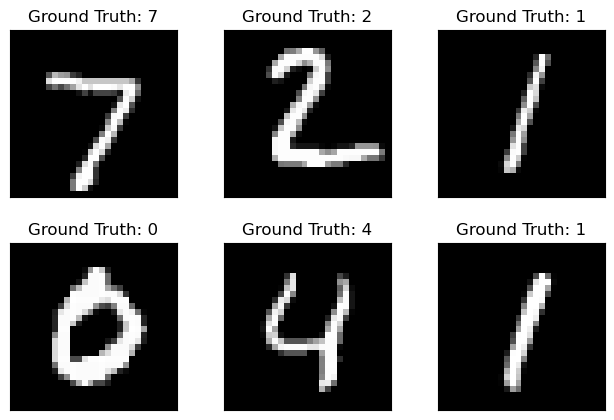

In [8]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1) #2 rows, 3 columns. 1 2 3, (next row) 4 5 6
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

#plt.savefig('figure.png', dpi=300, bbox_inches='tight')
#plt.close(fig)  # Close the figure window


In [9]:
pytorch_model #(train_set[10])
# ConvertModel(
#   (Flatten_11): Flatten() 28x28
#   (Gemm_12): Linear(in_features=784, out_features=256, bias=True)
#   (Relu_13): ReLU(inplace=True)
#   (Gemm_14): Linear(in_features=256, out_features=256, bias=True)
#   (Relu_15): ReLU(inplace=True)
#   (Gemm_16): Linear(in_features=256, out_features=256, bias=True)
#   (Relu_17): ReLU(inplace=True)
#   (Gemm_18): Linear(in_features=256, out_features=256, bias=True)
#   (Relu_19): ReLU(inplace=True)
#   (Gemm_20): Linear(in_features=256, out_features=10, bias=True)
# )

ConvertModel(
  (Flatten_11): Flatten()
  (Gemm_12): Linear(in_features=784, out_features=256, bias=True)
  (Relu_13): ReLU(inplace=True)
  (Gemm_14): Linear(in_features=256, out_features=256, bias=True)
  (Relu_15): ReLU(inplace=True)
  (Gemm_16): Linear(in_features=256, out_features=256, bias=True)
  (Relu_17): ReLU(inplace=True)
  (Gemm_18): Linear(in_features=256, out_features=256, bias=True)
  (Relu_19): ReLU(inplace=True)
  (Gemm_20): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


# Attach the hook to the 1st layer
pytorch_model.Relu_13.register_forward_hook(get_activation('relu1'))
pytorch_model.Relu_15.register_forward_hook(get_activation('relu2'))
pytorch_model.Relu_17.register_forward_hook(get_activation('relu3'))
pytorch_model.Relu_19.register_forward_hook(get_activation('relu4'))


{
“1”: { “relu”:[0,1,2,3…], “states”:[0,0,[0,3],[1,4]…]}
}

In [11]:
file = open(f'{os.getcwd()}/non_zero_neurons_relu4.txt', 'r')
contents = file.read()
file.close()
neurons_relu4 = [int(num) for num in contents.replace('\n', '').split(',') if num]
file = open(f'{os.getcwd()}/non_zero_neurons_relu3.txt', 'r')
contents = file.read()
file.close()
neurons_relu3 = [int(num) for num in contents.replace('\n', '').split(',') if num]
file = open(f'{os.getcwd()}/non_zero_neurons_relu2.txt', 'r')
contents = file.read()
file.close()
neurons_relu2 = [int(num) for num in contents.replace('\n', '').split(',') if num]
file = open(f'{os.getcwd()}/non_zero_neurons_relu1.txt', 'r')
contents = file.read()
file.close()
neurons_relu1 = [int(num) for num in contents.replace('\n', '').split(',') if num]

In [12]:
import json

with open("all_relu4", "r") as fp:
    relu4 = json.load(fp)
with open("all_relu3", "r") as fp:
    relu3 = json.load(fp)
with open("all_relu2", "r") as fp:
    relu2 = json.load(fp)
with open("all_relu1", "r") as fp:
    relu1 = json.load(fp)


In [60]:

def compare_two_lists(list1,list2,l1,l2):
    mean1=np.mean(list1)
    mean2=np.mean(list2)
    if (mean1<mean2 and (mean1+np.std(list1) >= mean2-np.std(list2)) or (mean1>=mean2 and (mean2+np.std(list2) >= mean1-np.std(list1)))): #quantile?
        range=(min(min(list1), min(list2)), max((max(list1), max(list2))))
        l1.extend(l2)
        #print("merge")
        return [[l1,range]]

    l_list, r_list=list1,list2
    label1,label2=l1,l2
    if max(list1)>=max(list2): #use max is more reasonable!
        r_list=list1
        l_list=list2
        label1, label2=l2,l1

    throwaway_1=0
    throwaway_2=0
    len1=len(l_list)
    len2=len(r_list)
    #sum([1 for x in data if x>np.percentile(data, 0.9)])
    while (max(l_list)>np.percentile(l_list,0.9) and min(r_list)<np.percentile(r_list, 0.1)) and (not max(l_list)<min(r_list)): #while(throwaway_1<(len1*0.1) and throwaway_2<(len2*0.1) and (not max(l_list)<min(r_list))):
        l_list.remove(max(l_list))
        throwaway_1+=1
        r_list.remove(min(r_list))
        throwaway_2+=1

    if max(l_list)>min(r_list):
        middle_split=(max(l_list)+min(r_list))/2
        return [label1,(min(l_list),middle_split)],[label2,(middle_split,max(r_list))]
    return [label1,(min(l_list),max(l_list))],[label2,(min(r_list),max(r_list))]


def cluster_things(layer, neuron,labels):
    clusters = [[[label],()] for label in labels]  # Start with each thing in its own cluster

    i = 0
    while i < len(clusters):
        has_merged = False
        current_cluster = clusters[i]
        cur_combined_list = []
        for label in current_cluster[0]:
            cur_combined_list.extend(relus[layer][neuron][label].copy())

        for j in range(i + 1, len(clusters)):
            other_cluster = clusters[j]
            other_combined_list = []
            for label in other_cluster[0]:
                other_combined_list.extend(relus[layer][neuron][label].copy())

            r = compare_two_lists(cur_combined_list, other_combined_list, current_cluster[0].copy(), other_cluster[0].copy()) #otherwise don't copy and comment out clusters[i][0]=r[0][0]

            if len(r)==1:
                clusters[i][0]=r[0][0]
                clusters[i][1]=r[0][1]
                del clusters[j]
                has_merged = True
                break  # Start over with the newly merged cluster
            else:
                clusters[i][1]=r[0][1]
                clusters[j][1]=r[1][1]

        if not has_merged:
            i += 1  # Move on to the next cluster if no merge happened

    return clusters

# Example usage
#neuron=226
things = [1,5,6]
final_clusters = cluster_things(3,226,things)
print(final_clusters)
#compare_two_lists(relu4[226][1].copy()+relu4[226][5].copy(),relu4[226][6].copy(),[1,5],[6])

[[[1, 5], (0.0, 0.6523311734199524)], [[6], (0.6523311734199524, 2.307821035385132)]]


In [25]:
c=[6]
for i in c:
    print(i)

6


In [30]:
neuron_dict={}
for i in cluster_things(226,things):
    for label in i[0]:
        neuron_dict[label]=i[1]
full_neuron_dict={}
for i in range(10):
    if i in neuron_dict:
        full_neuron_dict[i]=neuron_dict[i]
    else:
        full_neuron_dict[i]=0
full_neuron_dict

{0: 0,
 1: (0.0, 0.6643298864364624),
 2: 0,
 3: 0,
 4: 0,
 5: (0.0, 0.6643298864364624),
 6: (0.6643298864364624, 2.4351398944854736),
 7: 0,
 8: 0,
 9: 0}

In [58]:
relus[0][6][10]

IndexError: list index out of range

In [65]:
graph=False
# Create subplots for each label
#fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))  # Adjust figsize as needed
relus=[relu1,relu2,relu3,relu4]
#layer=4 #TODO: here ·
layer4_states={}
final_structure={}
neurons=[neurons_relu1, neurons_relu2, neurons_relu3, neurons_relu4]
# Plot histograms for each label
for layer in range(4):
    layer_states={}
    for neuron_index, neuron in enumerate(neurons[layer]): #TODO: here
      if graph:
          fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
          fig.suptitle(f'Neuron {neuron} in {layer}', fontsize=16,y=1)
          fig.subplots_adjust(top=0.95)

      #neuron_max=max(max(x) for x in relus[layer][neuron]) #TODO: here
      labels=[]

      for label in range(10):  # Assuming 10 labels
        data=relus[layer][neuron][label] #TODO: here
        data.remove(max(data))
        median = np.median(data)
        if(max(data)==0) or ((len(data)-data.count(0))/len(data))<0.025 or median==0: #or np.median(data)==0:
          continue

        #print(layer3_states[neuron])
        mean = np.mean(data)
        std = np.std(data)
        max_val=max(data)
        labels.append(label)

      if len(labels)==1:
        #print([labels,(min(data),max(data))])
        layer_states[neuron]=[[labels,(min(data),max(data))]]

      if len(labels)>1:
        #print(f"layers {layer}, neuron {neuron}, label {i}")
        #print(cluster_things(neuron, labels)[0])
        layer_states[neuron]=cluster_things(layer, neuron, labels)

        neuron_dict={}
        for i in layer_states[neuron]:
            for label in i[0]:
                neuron_dict[label]=i[1]
        full_neuron_dict={}
        for i in range(10):
            if i in neuron_dict:
                full_neuron_dict[i]=neuron_dict[i]
            else:
                full_neuron_dict[i]=0

        final_structure[neuron+(layer*256)]=full_neuron_dict
        #print(f"{neuron}: {full_neuron_dict}")

    #print(final_structure)
# with open("relu4_states", "w") as fp:
#   json.dump(layer4_states, fp)

In [66]:
# The final structure to be written to JSON
json_dict = {}

for label in range(10):
    # Initialize neuron and states list for each label
    neuron_list = []
    states_list = []

    # Iterate through the neuron_states to fill the structure
    for neuron, value in final_structure.items():
        # Check if the current label is in the list of labels for this neuron
        neuron_list.append(neuron)
        states_list.append(value.get(label))

    json_dict["class "+str(label)] = {'neuron': neuron_list, 'states': states_list}
print(json_dict)
# Write the structure to a JSON file
with open('output.json', 'w') as json_file:
    json.dump(json_dict, json_file, indent=4)

{'class 0': {'neuron': [6, 8, 11, 29, 30, 49, 69, 76, 86, 89, 93, 94, 97, 102, 105, 114, 120, 122, 123, 132, 144, 147, 161, 167, 176, 179, 181, 184, 187, 188, 190, 196, 197, 199, 213, 219, 247, 250, 251, 256, 259, 262, 263, 269, 274, 276, 277, 290, 292, 293, 297, 298, 299, 300, 301, 304, 305, 309, 311, 313, 314, 315, 321, 323, 324, 329, 330, 334, 338, 339, 346, 347, 351, 352, 358, 359, 360, 362, 364, 366, 367, 370, 371, 374, 376, 378, 384, 387, 388, 390, 396, 397, 400, 401, 404, 413, 415, 421, 434, 435, 436, 443, 447, 449, 462, 464, 468, 470, 477, 480, 482, 486, 489, 490, 494, 496, 497, 499, 500, 501, 502, 504, 508, 509, 510, 804, 823, 843, 844, 849, 854, 861, 874, 875, 888, 892, 897, 903, 910, 911, 912, 918, 925, 934, 937, 947, 951, 959, 964, 979, 985, 992, 994, 997, 1003, 1007, 1009, 1016], 'states': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, (0.0, 12.971648216247559), 0, 0, 0, (0.0, 19.701799392700195), 0, 0, 0, 0, 0, 0, (0.0, 13.803712844848633), 0, 0, 0, 0, 0, 0, (0.0, 14.7914457321167), 0, (

In [17]:
graph=False
# Create subplots for each label
#fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))  # Adjust figsize as needed

layer=4 #TODO: here ·
layer2_validneurons=[]
layer4_states={}
# Plot histograms for each label
for neuron_index, neuron in enumerate(neurons_relu4): #TODO: here
  #print(neuron)
  if graph:
      fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
      fig.suptitle(f'Neuron {neuron} in {layer}', fontsize=16,y=1)
      fig.subplots_adjust(top=0.95)

  neuron_max=max(max(x) for x in relu4[neuron]) #TODO: here
  labels=[]

  for i in range(10):  # Assuming 10 labels

    #ax = axes[i]
    data=relu4[neuron][i] #TODO: here
        #print(f'mean of label {i}: {np.mean(list_of_lists[i])} \n std of label {i}: {np.std(list_of_lists[i])}')
    # temp_fig = plt.figure()
    # counts, bin_edges, patches = plt.hist(data, bins=20)  # Adjust the number of bins as necessary
    # plt.close(temp_fig)
    #if ((len(data)-data.count(0))/len(data))<0.05 or np.median(data)==0:#((len(data)-data.count(0))/len(data))<0.05:#median!=0:#len(counts)<3:#counts[0] > max(counts[1:]):  # Check if the first bin count is higher than the rest
      #continue
    data.remove(max(data))
    median = np.median(data)
    if(max(data)==0) or ((len(data)-data.count(0))/len(data))<0.025 or median==0: #or np.median(data)==0:
      continue

    #print(layer3_states[neuron])
    mean = np.mean(data)
    std = np.std(data)
    max_val=max(data)
    labels.append(i)



    # print(f"neuron:{neuron}, label{i}: range:{mean-std}, {mean+std},")
    # ax.hist(data, bins=20, color='red', alpha=0.5, label=f'Neuron {neuron_index+1}') #width=0.1
    # ax.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    # ax.axvline(max_val, color='r', linestyle='dotted', linewidth=2, label=f'Max: {max_val:.2f}')
    # ax.axvline(median, color='g', linestyle='dotted', linewidth=2, label=f'Median: {median:.2f}')
    # ax.axvline(mean - std, color='b', linestyle='dashed', linewidth=1, label=f'Std Dev: {std:.2f}')
    # ax.axvline(mean + std, color='b', linestyle='dashed', linewidth=1)
    # ax.set_xlim([-1, neuron_max])
    # ax.legend()
    #
    # ax.set_title(f'Label {i} (nonzero datapoints: {(len(data)-data.count(0))}/{len(data)})')
    # ax.set_xlabel('Value')
    # ax.set_ylabel('Frequency')


  if len(labels)==1:
    #print([labels,(min(data),max(data))])
    layer4_states[neuron]=[labels,(min(data),max(data))]
  if len(labels)>1:
    #print(cluster_things(neuron, labels)[0])
    layer4_states[neuron]=cluster_things(neuron, labels)[0]
    #layer2_validneurons.append(neuron)
    #axes[0].legend()
    #plt.tight_layout()
    #plt.savefig(f'neurons/layer{layer}_states/{neuron}')
    #plt.show()
  #plt.close()
print(layer4_states)
with open("relu4_states", "w") as fp:
  json.dump(layer4_states, fp)

{2: [[2], (0.0, 0.4821324646472931)], 9: [[1], (0.0, 0.2175278216600418)], 14: [[8], (0.0, 0.4400275945663452)], 24: [[4], (0.0, 0.9215868711471558)], 25: [[7], (0.0, 0.10458655655384064)], 29: [[2], (0.0, 0.0)], 36: [[1, 3], (0.0, 0.2977808117866516)], 37: [[3], (0.0, 0.39495399594306946)], 46: [[9], (0.0, 3.134911060333252)], 55: [[4], (0.0, 0.5746097564697266)], 69: [[8], (0.0, 0.0)], 75: [[3], (0.0, 0.4486162066459656)], 76: [[1, 9], (0.0, 0.18701526522636414)], 81: [[2, 8], (0.0, 0.45902377367019653)], 85: [[0], (0.0, 0.0)], 86: [[3], (0.0, 0.41543257236480713)], 93: [[4], (0.0, 0.32265371084213257)], 105: [[7], (0.0, 0.0)], 106: [[0], (0.0, 0.224144846200943)], 107: [[1], (0.0, 0.6939896941184998)], 120: [[0], (0.0, 0.19918952882289886)], 124: [[0], (0.0, 0.28949350118637085)], 129: [[0, 8], (0.0, 0.43375009298324585)], 133: [[6], (0.0, 0.0)], 135: [[5], (0.0, 0.2769327461719513)], 142: [[0], (0.0, 0.2834998369216919)], 143: [[2, 8], (0.0, 0.36322736740112305)], 144: [[2], (0.0, 